In [8]:
using Pkg
if haskey(ENV,"COLAB_RELEASE_TAG")
  Pkg.add(url="https://github.com/emmacware/Droplets.jl")
  Pkg.add("CPUTime")
end
using Droplets, Random, CPUTime, Plots


In [9]:
# Create the settings for the simulation
FT = Float64

#coagsettings
coagsettings = coag_settings{FT}(
    Ns = 2^14,
    Δt = FT(1.0),
    ΔV = FT(1e6),
    golovin_kernel_coeff = FT(1.5e3),
    kernel = golovin,
    n0 = FT(2^23),
    R0 = FT(30.531e-6),
)

#runsettings
runsettings=run_settings{FT}(
    num_bins= 128,
    init_random_seed = 30,
    output_steps = [0,1200,2400,3600],
    init_method = init_logarithmic,
    binning_method = mass_density_lnr,
)

run_settings{Float64}(128, [1.0e-5, 1.0497495645498898e-5, 1.1019741482726832e-5, 1.1567968822944827e-5, 1.2143470234613033e-5, 1.274760259090958e-5, 1.3381790268862351e-5, 1.4047528507636206e-5, 1.474638693389327e-5, 1.5480013262538644e-5  …  0.003229971392918577, 0.0033906610632248773, 0.003559344974656581, 0.003736420837228581, 0.0039223061468558335, 0.004117439169693268, 0.0043222799754461675, 0.004537311522087318, 0.004763040794538355, 0.004999999999999999], true, 2, 30, Serial(), none(), [0.0, 1200.0, 2400.0, 3600.0], Droplets.init_logarithmic, Droplets.mass_density_lnr, true)

In [10]:
# Initialize the Superdroplets
drops = runsettings.init_method(coagsettings)

Droplets.simple_droplet_attributes{Float64}([1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  3, 2, 2, 2, 2, 2, 2, 2, 2, 2], [9.004765323640947e-24, 9.016337293948283e-24, 9.024765645332177e-24, 9.038503434260439e-24, 9.059051613442408e-24, 9.079150047720219e-24, 9.092660781752436e-24, 9.106811965123075e-24, 9.123775351449788e-24, 9.137947957652058e-24  …  3.0589454625798102e-12, 3.0676713781379355e-12, 3.0722706678205022e-12, 3.0775528690080414e-12, 3.07965947326515e-12, 3.087823260796182e-12, 3.0884848299177436e-12, 3.094886778344966e-12, 3.1025786196182756e-12, 3.1045982402886053e-12])

In [11]:
# Create the Simulation
function coag_runtime(randseed::Int,droplets::droplet_attributes,
    coag_settings::coag_settings{FT},run_settings::run_settings{FT}) where FT<:AbstractFloat

    Random.seed!(randseed)
    println("Running simulation...")

    coal_func_time::FT = 0.0
    bins::Matrix{FT} = zeros(FT, run_settings.num_bins, length(run_settings.output_steps))
    threading,scheme = run_settings.coag_threading, run_settings.scheme
    coag_data = coagulation_run{FT}(coag_settings.Ns)
    simtime::FT = @CPUelapsed begin
        for i  in  1:length(run_settings.output_steps)
            if i !=1
                timestepper = (run_settings.output_steps[i]-run_settings.output_steps[i-1])/coag_settings.Δt
                ctime::FT = @CPUelapsed begin
                    for _ in 1:timestepper
                        coalescence_timestep!(threading,scheme,droplets,coag_data,coag_settings)
                    end
                end
                coal_func_time += ctime
            end
            bins[:,i] = binning_func(droplets,run_settings.output_steps[i],run_settings,coag_settings)
        end
    end
    println("simtime =", simtime)
    println("coal_func_time =", coal_func_time)

    return bins, coal_func_time
end

coag_runtime (generic function with 1 method)

In [12]:
# Run the Simulation
bins,times = coag_runtime(1,drops,coagsettings,runsettings)

Running simulation...
simtime =0.592461
coal_func_time =0.588912


([1.6559865661413515e-5 2.808094860162369e-6 4.127699372378265e-7 6.728523101926825e-8; 5.518987459588872e-6 2.205333091424252e-6 3.3996433226700117e-7 5.5370819402834085e-8; … ; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0], 0.588912)

In [13]:
# Create Plotting function for the DSD
function plot_dsd(bins,runsettings::run_settings{FT},coagsettings::coag_settings{FT};color="black",label=false,legend=true) where FT<:AbstractFloat
    radius_bins_edges = runsettings.radius_bins_edges
    mids = 0.5*(radius_bins_edges[1:end-1] + radius_bins_edges[2:end])*1e6
    if coagsettings.kernel == golovin
        plot1 = plot!(mids,density_lnr_golovin_analytic(runsettings,coagsettings),xaxis=:log,color=:black,linestyle=:dash,label=false)
        plot!(mids[1:2,1],[0,0],color=:black,linestyle=:dash,label="Analytic Soln")
    end
    plot1 = plot!(mids,bins,xaxis=:log,label= runsettings.output_steps',legend=legend,legendtitle="Time Steps (s)")
    

    
    xlabel!("Radius (μm)")
    if runsettings.binning_method == number_density
        ylabel!("Number density (m^-3)")
    elseif runsettings.binning_method == mass_density_lnr
        ylabel!("Mass density (kg m^-3)")
    end
    title!("Time Evolution of Droplet Size Distribution")

    return plot1
end

plot_dsd (generic function with 1 method)

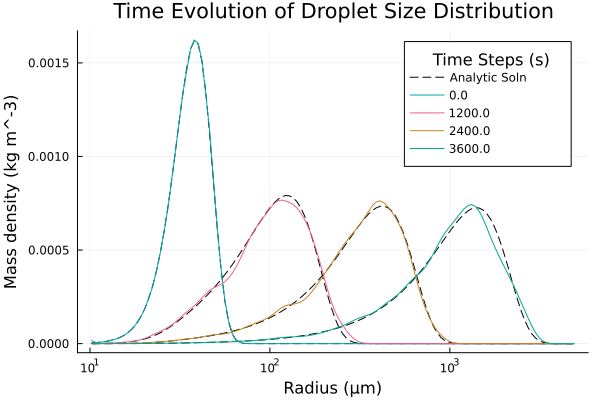

In [14]:
#Plot the DSD
plot()
plot_dsd(bins,runsettings,coagsettings)